![ML Logo](http://spark-mooc.github.io/web-assets/images/CS190.1x_Banner_300.png)
# **Principal Component Analysis Lab**
#### This lab delves into exploratory analysis of neuroscience data, specifically using principal component analysis (PCA) and feature-based aggregation. We will use a dataset of light-sheet imaging recorded by the [Ahrens Lab](http://www.janelia.org/lab/ahrens-lab) at Janelia Research Campus, and hosted on the CodeNeuro [data repository](http://datasets.codeneuro.org).
#### Our dataset is generated by studying the movement of a larval [zebrafish](http://en.wikipedia.org/wiki/Zebrafish), an animal that is especially useful in neuroscience because it is transparent, making it possible to record activity over its entire brain using a technique called [light-sheet microscopy](http://en.wikipedia.org/wiki/Light_sheet_fluorescence_microscopy).   Specifically, we'll work with time-varying images containing patterns of the zebrafish's neural activity as it is presented with a moving visual pattern.   Different stimuli induce different patterns across the brain, and we can use exploratory analyses to identify these patterns.  Read ["Mapping brain activity at scale with cluster computing"](http://thefreemanlab.com/work/papers/freeman-2014-nature-methods.pdf) for more information about these kinds of analyses.
#### During this lab you will learn about PCA, and then compare and contrast different exploratory analyses of the same data set to identify which neural patterns they best highlight.
#### ** This lab will cover: **
+  ####*Part 1:* Work through the steps of PCA on a sample dataset
 + ####*Visualization 1:* Two-dimensional Gaussians
+  ####*Part 2:* Write a PCA function and evaluate PCA on sample datasets
 + ####*Visualization 2:* PCA projection
 + ####*Visualization 3:* Three-dimensional data
 + ####*Visualization 4:* 2D representation of 3D data
+  ####*Part 3:* Parse, inspect, and preprocess neuroscience data then perform PCA
 + ####*Visualization 5:* Pixel intensity
 + ####*Visualization 6:* Normalized data
 + ####*Visualization 7:* Top two components as images
 + ####*Visualization 8:* Top two components as one image
+  ####*Part 4:* Perform feature-based aggregation followed by PCA
 + ####*Visualization 9:* Top two components by time
 + ####*Visualization 10:* Top two components by direction
 
#### Note that, for reference, you can look up the details of the relevant Spark methods in [Spark's Python API](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD) and the relevant NumPy methods in the [NumPy Reference](http://docs.scipy.org/doc/numpy/reference/index.html)

In [1]:
labVersion = 'cs190_week5_v_1_2'

 
### **Part 1: Work through the steps of PCA on a sample dataset**

#### **Visualization 1: Two-dimensional Gaussians**
#### Principal Component Analysis, or PCA, is a strategy for dimensionality reduction. To better understand PCA, we'll work with synthetic data generated by sampling from the [two-dimensional Gaussian distribution](http://en.wikipedia.org/wiki/Multivariate_normal_distribution).  This distribution takes as input the mean and variance of each dimension, as well as the covariance between the two dimensions.
 
#### In our visualizations below, we will specify the mean of each dimension to be 50 and the variance along each dimension to be 1.  We will explore two different values for the covariance: 0 and 0.9. When the covariance is zero, the two dimensions are uncorrelated, and hence the data looks spherical.  In contrast, when the covariance is 0.9, the two dimensions are strongly (positively) correlated and thus the data is non-spherical.  As we'll see in Parts 1 and 2, the non-spherical data is amenable to dimensionality reduction via PCA, while the spherical data is not.

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def preparePlot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                gridWidth=1.0):
    """Template for generating the plot layout."""
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

def create2DGaussian(mn, sigma, cov, n):
    """Randomly sample points from a two-dimensional Gaussian distribution"""
    np.random.seed(142)
    return np.random.multivariate_normal(np.array([mn, mn]), np.array([[sigma, cov], [cov, sigma]]), n)

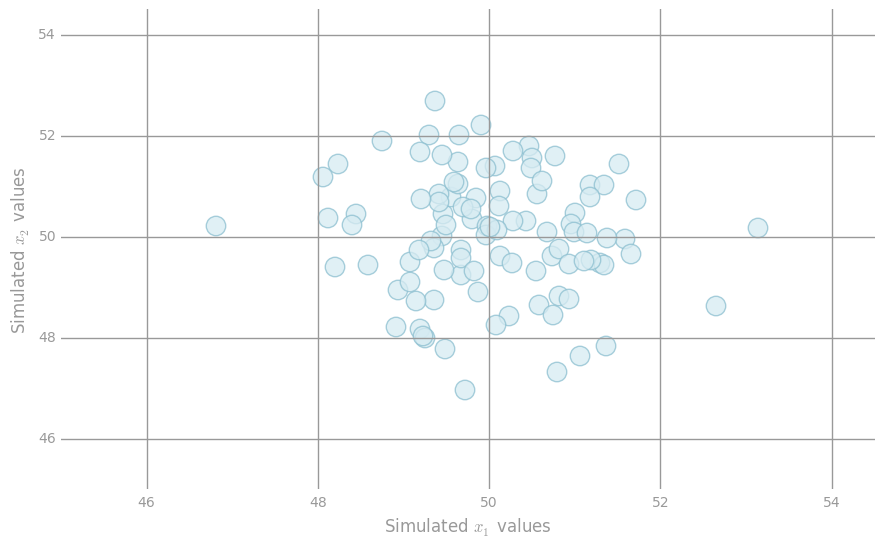

In [3]:
dataRandom = create2DGaussian(mn=50, sigma=1, cov=0, n=100)

# generate layout and plot data
fig, ax = preparePlot(np.arange(46, 55, 2), np.arange(46, 55, 2))
ax.set_xlabel(r'Simulated $x_1$ values'), ax.set_ylabel(r'Simulated $x_2$ values')
ax.set_xlim(45, 54.5), ax.set_ylim(45, 54.5)
plt.scatter(dataRandom[:,0], dataRandom[:,1], s=14**2, c='#d6ebf2', edgecolors='#8cbfd0', alpha=0.75)
pass

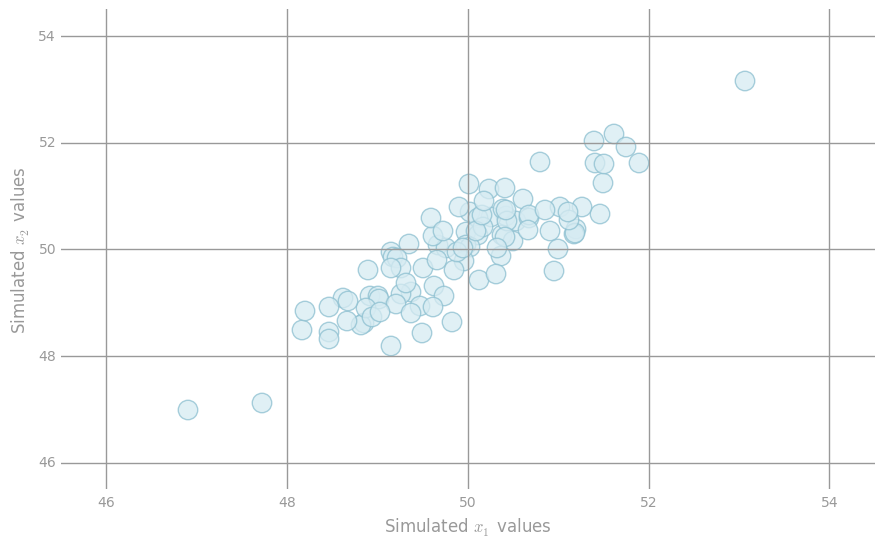

In [4]:
dataCorrelated = create2DGaussian(mn=50, sigma=1, cov=.9, n=100)

# generate layout and plot data
fig, ax = preparePlot(np.arange(46, 55, 2), np.arange(46, 55, 2))
ax.set_xlabel(r'Simulated $x_1$ values'), ax.set_ylabel(r'Simulated $x_2$ values')
ax.set_xlim(45.5, 54.5), ax.set_ylim(45.5, 54.5)
plt.scatter(dataCorrelated[:,0], dataCorrelated[:,1], s=14**2, c='#d6ebf2',
            edgecolors='#8cbfd0', alpha=0.75)
pass

#### **(1a) Interpreting PCA**
#### PCA can be interpreted as identifying the "directions" along which the data vary the most. In the first step of PCA, we must first center our data.  Working with our correlated dataset, first compute the mean of each feature (column) in the dataset.  Then for each observation, modify the features by subtracting their corresponding mean, to create a zero mean dataset.
#### Note that `correlatedData` is an RDD of NumPy arrays.  This allows us to perform certain operations more succinctly.  For example, we can sum the columns of our dataset using `correlatedData.sum()`.

In [5]:
# TODO: Replace <FILL IN> with appropriate code
correlatedData = sc.parallelize(dataCorrelated)

meanCorrelated = correlatedData.mean()
correlatedDataZeroMean = correlatedData.map(lambda a: a - meanCorrelated)

print meanCorrelated
print correlatedData.take(1)
print correlatedDataZeroMean.take(1)

[ 49.95739037  49.97180477]
[array([ 49.6717712 ,  50.07531969])]
[array([-0.28561917,  0.10351492])]


In [6]:
# TEST Interpreting PCA (1a)
from test_helper import Test
Test.assertTrue(np.allclose(meanCorrelated, [49.95739037, 49.97180477]),
                'incorrect value for meanCorrelated')
Test.assertTrue(np.allclose(correlatedDataZeroMean.take(1)[0], [-0.28561917, 0.10351492]),
                'incorrect value for correlatedDataZeroMean')

1 test passed.
1 test passed.


#### **(1b) Sample covariance matrix**
#### We are now ready to compute the sample covariance matrix. If we define $\scriptsize \mathbf{X} \in \mathbb{R}^{n \times d}$ as the zero mean data matrix, then the sample covariance matrix is defined as: $$ \mathbf{C}_{\mathbf X} = \frac{1}{n} \mathbf{X}^\top \mathbf{X} \,.$$  To compute this matrix, compute the outer product of each data point, add together these outer products, and divide by the number of data points. The data are two dimensional, so the resulting covariance matrix should be a 2x2 matrix.
 
#### Note that [np.outer()](http://docs.scipy.org/doc/numpy/reference/generated/numpy.outer.html) can be used to calculate the outer product of two NumPy arrays.

In [7]:
# TODO: Replace <FILL IN> with appropriate code
# Compute the covariance matrix using outer products and correlatedDataZeroMean
correlatedCov = correlatedDataZeroMean.map(lambda a: np.outer(a, a.T)).mean()
print correlatedCov

[[ 0.99558386  0.90148989]
 [ 0.90148989  1.08607497]]


In [8]:
# TEST Sample covariance matrix (1b)
covResult = [[ 0.99558386,  0.90148989], [0.90148989, 1.08607497]]
Test.assertTrue(np.allclose(covResult, correlatedCov), 'incorrect value for correlatedCov')

1 test passed.


#### **(1c) Covariance Function**
#### Next, use the expressions above to write a function to compute the sample covariance matrix for an arbitrary `data` RDD.

In [9]:
# TODO: Replace <FILL IN> with appropriate code
def estimateCovariance(data):
    """Compute the covariance matrix for a given rdd.

    Note:
        The multi-dimensional covariance array should be calculated using outer products.  Don't
        forget to normalize the data by first subtracting the mean.

    Args:
        data (RDD of np.ndarray):  An `RDD` consisting of NumPy arrays.

    Returns:
        np.ndarray: A multi-dimensional array where the number of rows and columns both equal the
            length of the arrays in the input `RDD`.
    """
    meanCorrelated = data.mean()
    correlatedDataZeroMean = data.map(lambda a: a - meanCorrelated)
    return correlatedDataZeroMean.map(lambda a: np.outer(a, a.T)).mean()

correlatedCovAuto= estimateCovariance(correlatedData)
print correlatedCovAuto

[[ 0.99558386  0.90148989]
 [ 0.90148989  1.08607497]]


In [10]:
# TEST Covariance function (1c)
correctCov = [[ 0.99558386,  0.90148989], [0.90148989, 1.08607497]]
Test.assertTrue(np.allclose(correctCov, correlatedCovAuto),
                'incorrect value for correlatedCovAuto')

1 test passed.


#### **(1d) Eigendecomposition**
#### Now that we've computed the sample covariance matrix, we can use it to find directions of maximal variance in the data.  Specifically, we can perform an eigendecomposition of this matrix to find its eigenvalues and eigenvectors.  The $\scriptsize d $ eigenvectors of the covariance matrix give us the directions of maximal variance, and are often called the "principal components."  The associated eigenvalues are the variances in these directions.  In particular, the eigenvector corresponding to the largest eigenvalue is the direction of maximal variance (this is sometimes called the "top" eigenvector). Eigendecomposition of a $\scriptsize d \times d $ covariance matrix has a (roughly) cubic runtime complexity with respect to $\scriptsize d $.  Whenever $\scriptsize d $ is relatively small (e.g., less than a few thousand) we can quickly perform this eigendecomposition locally.
 
#### Use a function from `numpy.linalg` called [eigh](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eigh.html) to perform the eigendecomposition.  Next, sort the eigenvectors based on their corresponding eigenvalues (from high to low), yielding a matrix where the columns are the eigenvectors (and the first column is the top eigenvector).  Note that [np.argsort](http://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html#numpy-argsort) can be used to obtain the indices of the eigenvalues that correspond to the ascending order of eigenvalues.  Finally, set the `topComponent` variable equal to the top eigenvector or prinicipal component, which is a $\scriptsize 2 $-dimensional vector (array with two values).
#### Note that the eigenvectors returned by `eigh` appear in the columns and not the rows.  For example, the first eigenvector of `eigVecs` would be found in the first column and could be accessed using `eigVecs[:,0]`.

In [11]:
# TODO: Replace <FILL IN> with appropriate code
from numpy.linalg import eigh

# Calculate the eigenvalues and eigenvectors from correlatedCovAuto
eigVals, eigVecs = eigh(correlatedCovAuto)
print 'eigenvalues: {0}'.format(eigVals)
print '\neigenvectors: \n{0}'.format(eigVecs)

# Use np.argsort to find the top eigenvector based on the largest eigenvalue
inds = np.argsort(eigVals)[-1]
topComponent = eigVecs[inds]
print '\ntop principal component: {0}'.format(topComponent)

eigenvalues: [ 0.13820481  1.94345403]

eigenvectors: 
[[-0.72461254  0.68915649]
 [ 0.68915649  0.72461254]]

top principal component: [ 0.68915649  0.72461254]


In [12]:
# TEST Eigendecomposition (1d)
def checkBasis(vectors, correct):
    return np.allclose(vectors, correct) or np.allclose(np.negative(vectors), correct)
Test.assertTrue(checkBasis(topComponent, [0.68915649, 0.72461254]),
                'incorrect value for topComponent')

1 test passed.


#### **(1e) PCA scores**
#### We just computed the top principal component for a 2-dimensional non-spherical dataset.  Now let's use this principal component to derive a one-dimensional representation for the original data. To compute these compact representations, which are sometimes called PCA "scores", calculate the dot product between each data point in the raw data and the top principal component.

In [13]:
# TODO: Replace <FILL IN> with appropriate code
# Use the topComponent and the data from correlatedData to generate PCA scores
correlatedDataScores = correlatedData.map(lambda x: x.dot(topComponent))
print 'one-dimensional data (first three):\n{0}'.format(np.asarray(correlatedDataScores.take(3)))

one-dimensional data (first three):
[ 70.51682806  69.30622356  71.13588168]


In [14]:
# TEST PCA Scores (1e)
firstThree = [70.51682806, 69.30622356, 71.13588168]
Test.assertTrue(checkBasis(correlatedDataScores.take(3), firstThree),
                'incorrect value for correlatedDataScores')

1 test passed.


### **Part 2: Write a PCA function and evaluate PCA on sample datasets**

#### **(2a) PCA function**
#### We now have all the ingredients to write a general PCA function.  Instead of working with just the top principal component, our function will compute the top $\scriptsize k$ principal components and principal scores for a given dataset. Write this general function `pca`, and run it with `correlatedData` and $\scriptsize k = 2$. Hint: Use results from Part (1c), Part (1d), and Part (1e).
 
####Note: As discussed in lecture, our implementation is a reasonable strategy when $\scriptsize d $ is small, though more efficient distributed algorithms exist when $\scriptsize d $ is large.

In [15]:
# TODO: Replace <FILL IN> with appropriate code
def pca(data, k=2):
    """Computes the top `k` principal components, corresponding scores, and all eigenvalues.

    Note:
        All eigenvalues should be returned in sorted order (largest to smallest). `eigh` returns
        each eigenvectors as a column.  This function should also return eigenvectors as columns.

    Args:
        data (RDD of np.ndarray): An `RDD` consisting of NumPy arrays.
        k (int): The number of principal components to return.

    Returns:
        tuple of (np.ndarray, RDD of np.ndarray, np.ndarray): A tuple of (eigenvectors, `RDD` of
            scores, eigenvalues).  Eigenvectors is a multi-dimensional array where the number of
            rows equals the length of the arrays in the input `RDD` and the number of columns equals
            `k`.  The `RDD` of scores has the same number of rows as `data` and consists of arrays
            of length `k`.  Eigenvalues is an array of length d (the number of features).
    """
    correlatedCovAuto = estimateCovariance(data)
    eigVals, eigVecs = eigh(correlatedCovAuto)
    inds = np.argsort(eigVals)[-k:][::-1]
    topK = eigVecs[:,inds]
    correlatedDataScores = data.map(lambda x: x.dot(topK))
    # Return the `k` principal components, `k` scores, and all eigenvalues
    return (topK, correlatedDataScores, eigVals[::-1])

# Run pca on correlatedData with k = 2
topComponentsCorrelated, correlatedDataScoresAuto, eigenvaluesCorrelated = pca(correlatedData, k=2)

# Note that the 1st principal component is in the first column
print 'topComponentsCorrelated: \n{0}'.format(topComponentsCorrelated)
print ('\ncorrelatedDataScoresAuto (first three): \n{0}'
       .format('\n'.join(map(str, correlatedDataScoresAuto.take(3)))))
print '\neigenvaluesCorrelated: \n{0}'.format(eigenvaluesCorrelated)

# Create a higher dimensional test set
pcaTestData = sc.parallelize([np.arange(x, x + 4) for x in np.arange(0, 20, 4)])
componentsTest, testScores, eigenvaluesTest = pca(pcaTestData, 3)

print '\npcaTestData: \n{0}'.format(np.array(pcaTestData.collect()))
print '\ncomponentsTest: \n{0}'.format(componentsTest)
print ('\ntestScores (first three): \n{0}'
       .format('\n'.join(map(str, testScores.take(3)))))
print '\neigenvaluesTest: \n{0}'.format(eigenvaluesTest)

topComponentsCorrelated: 
[[ 0.68915649 -0.72461254]
 [ 0.72461254  0.68915649]]

correlatedDataScoresAuto (first three): 
[ 70.51682806  -1.48305648]
[ 69.30622356  -1.5888655 ]
[ 71.13588168  -1.86710679]

eigenvaluesCorrelated: 
[ 1.94345403  0.13820481]

pcaTestData: 
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]
 [16 17 18 19]]

componentsTest: 
[[  5.00000000e-01   4.53720244e-18  -5.00842381e-01]
 [  5.00000000e-01  -6.56160918e-17  -4.99156909e-01]
 [  5.00000000e-01  -7.07106781e-01   4.99999645e-01]
 [  5.00000000e-01   7.07106781e-01   4.99999645e-01]]

testScores (first three): 
[ 3.          0.70710678  2.00084132]
[ 11.           0.70710678   2.00084132]
[ 19.           0.70710678   2.00084132]

eigenvaluesTest: 
[  1.28000000e+02  -1.40207700e-31  -3.70765989e-15  -1.94890624e-14]


In [16]:
# TEST PCA Function (2a)
Test.assertTrue(checkBasis(topComponentsCorrelated.T,
                           [[0.68915649,  0.72461254], [-0.72461254, 0.68915649]]),
                'incorrect value for topComponentsCorrelated')
firstThreeCorrelated = [[70.51682806, 69.30622356, 71.13588168], [1.48305648, 1.5888655, 1.86710679]]
Test.assertTrue(np.allclose(firstThreeCorrelated,
                            np.vstack(np.abs(correlatedDataScoresAuto.take(3))).T),
                'incorrect value for firstThreeCorrelated')
Test.assertTrue(np.allclose(eigenvaluesCorrelated, [1.94345403, 0.13820481]),
                           'incorrect values for eigenvaluesCorrelated')
topComponentsCorrelatedK1, correlatedDataScoresK1, eigenvaluesCorrelatedK1 = pca(correlatedData, 1)
Test.assertTrue(checkBasis(topComponentsCorrelatedK1.T, [0.68915649,  0.72461254]),
               'incorrect value for components when k=1')
Test.assertTrue(np.allclose([70.51682806, 69.30622356, 71.13588168],
                            np.vstack(np.abs(correlatedDataScoresK1.take(3))).T),
                'incorrect value for scores when k=1')
Test.assertTrue(np.allclose(eigenvaluesCorrelatedK1, [1.94345403, 0.13820481]),
                           'incorrect values for eigenvalues when k=1')
Test.assertTrue(checkBasis(componentsTest.T[0], [ .5, .5, .5, .5]),
                'incorrect value for componentsTest')
Test.assertTrue(np.allclose(np.abs(testScores.first()[0]), 3.),
                'incorrect value for testScores')
Test.assertTrue(np.allclose(eigenvaluesTest, [ 128, 0, 0, 0 ]), 'incorrect value for eigenvaluesTest')

1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.


#### **(2b) PCA on `dataRandom`**
#### Next, use the PCA function we just developed to find the top two principal components of the spherical `dataRandom` we created in Visualization 1.

In [17]:
# TODO: Replace <FILL IN> with appropriate code
randomData = sc.parallelize(dataRandom)

# Use pca on randomData
topComponentsRandom, randomDataScoresAuto, eigenvaluesRandom = pca(randomData)

print 'topComponentsRandom: \n{0}'.format(topComponentsRandom)
print ('\nrandomDataScoresAuto (first three): \n{0}'
       .format('\n'.join(map(str, randomDataScoresAuto.take(3)))))
print '\neigenvaluesRandom: \n{0}'.format(eigenvaluesRandom)

topComponentsRandom: 
[[-0.2522559  -0.96766056]
 [ 0.96766056 -0.2522559 ]]

randomDataScoresAuto (first three): 
[ 36.61068572 -61.3489929 ]
[ 35.97314295 -62.08813671]
[ 35.59836628 -60.61390415]

eigenvaluesRandom: 
[ 1.4204546   0.99521397]


In [18]:
# TEST PCA on `dataRandom` (2b)
Test.assertTrue(checkBasis(topComponentsRandom.T,
                           [[-0.2522559 ,  0.96766056], [-0.96766056,  -0.2522559]]),
                'incorrect value for topComponentsRandom')
firstThreeRandom = [[36.61068572,  35.97314295,  35.59836628],
                    [61.3489929 ,  62.08813671,  60.61390415]]
Test.assertTrue(np.allclose(firstThreeRandom, np.vstack(np.abs(randomDataScoresAuto.take(3))).T),
                'incorrect value for randomDataScoresAuto')
Test.assertTrue(np.allclose(eigenvaluesRandom, [1.4204546, 0.99521397]),
                            'incorrect value for eigenvaluesRandom')

1 test passed.
1 test passed.
1 test passed.


#### **Visualization 2: PCA projection**
#### Plot the original data and the 1-dimensional reconstruction using the top principal component to see how the PCA solution looks.  The original data is plotted as before; however, the 1-dimensional reconstruction (projection) is plotted in green on top of the original data and the vectors (lines) representing the two principal components are shown as dotted lines.

In [19]:
def projectPointsAndGetLines(data, components, xRange):
    """Project original data onto first component and get line details for top two components."""
    topComponent= components[:, 0]
    slope1, slope2 = components[1, :2] / components[0, :2]

    means = data.mean()[:2]
    demeaned = data.map(lambda v: v - means)
    projected = demeaned.map(lambda v: (v.dot(topComponent) /
                                        topComponent.dot(topComponent)) * topComponent)
    remeaned = projected.map(lambda v: v + means)
    x1,x2 = zip(*remeaned.collect())

    lineStartP1X1, lineStartP1X2 = means - np.asarray([xRange, xRange * slope1])
    lineEndP1X1, lineEndP1X2 = means + np.asarray([xRange, xRange * slope1])
    lineStartP2X1, lineStartP2X2 = means - np.asarray([xRange, xRange * slope2])
    lineEndP2X1, lineEndP2X2 = means + np.asarray([xRange, xRange * slope2])

    return ((x1, x2), ([lineStartP1X1, lineEndP1X1], [lineStartP1X2, lineEndP1X2]),
            ([lineStartP2X1, lineEndP2X1], [lineStartP2X2, lineEndP2X2]))

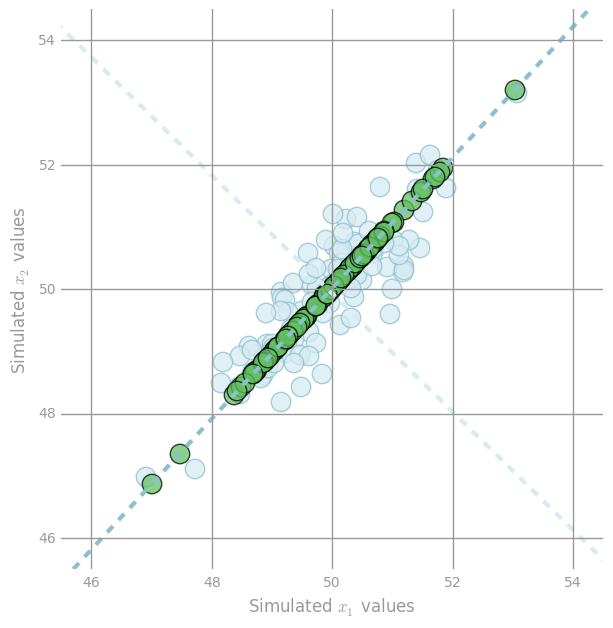

In [20]:
((x1, x2), (line1X1, line1X2), (line2X1, line2X2)) = \
    projectPointsAndGetLines(correlatedData, topComponentsCorrelated, 5)

# generate layout and plot data
fig, ax = preparePlot(np.arange(46, 55, 2), np.arange(46, 55, 2), figsize=(7, 7))
ax.set_xlabel(r'Simulated $x_1$ values'), ax.set_ylabel(r'Simulated $x_2$ values')
ax.set_xlim(45.5, 54.5), ax.set_ylim(45.5, 54.5)
plt.plot(line1X1, line1X2, linewidth=3.0, c='#8cbfd0', linestyle='--')
plt.plot(line2X1, line2X2, linewidth=3.0, c='#d6ebf2', linestyle='--')
plt.scatter(dataCorrelated[:,0], dataCorrelated[:,1], s=14**2, c='#d6ebf2',
            edgecolors='#8cbfd0', alpha=0.75)
plt.scatter(x1, x2, s=14**2, c='#62c162', alpha=.75)
pass

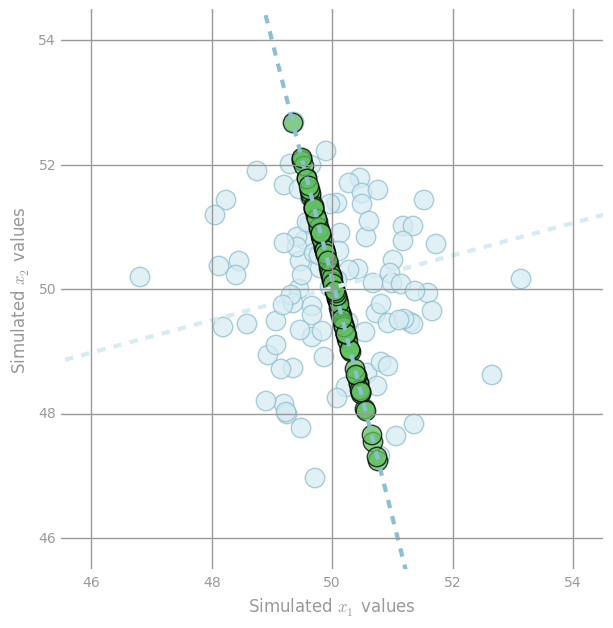

In [21]:
((x1, x2), (line1X1, line1X2), (line2X1, line2X2)) = \
    projectPointsAndGetLines(randomData, topComponentsRandom, 5)

# generate layout and plot data
fig, ax = preparePlot(np.arange(46, 55, 2), np.arange(46, 55, 2), figsize=(7, 7))
ax.set_xlabel(r'Simulated $x_1$ values'), ax.set_ylabel(r'Simulated $x_2$ values')
ax.set_xlim(45.5, 54.5), ax.set_ylim(45.5, 54.5)
plt.plot(line1X1, line1X2, linewidth=3.0, c='#8cbfd0', linestyle='--')
plt.plot(line2X1, line2X2, linewidth=3.0, c='#d6ebf2', linestyle='--')
plt.scatter(dataRandom[:,0], dataRandom[:,1], s=14**2, c='#d6ebf2',
            edgecolors='#8cbfd0', alpha=0.75)
plt.scatter(x1, x2, s=14**2, c='#62c162', alpha=.75)
pass

#### **Visualization 3: Three-dimensional data**
#### So far we have worked with two-dimensional data. Now let's generate three-dimensional data with highly correlated features. As in Visualization 1, we'll create samples from a multivariate Gaussian distribution, which in three dimensions requires us to specify three means, three variances, and three covariances.
 
#### In the 3D graphs below, we have included the 2D plane that corresponds to the top two principal components, i.e. the plane with the smallest euclidean distance between the points and itself. Notice that the data points, despite living in three-dimensions, are found near a two-dimensional plane: the left graph shows how most points are close to the plane when it is viewed from its side, while the right graph shows that the plane covers most of the variance in the data.  Note that darker blues correspond to points with higher values for the third dimension.

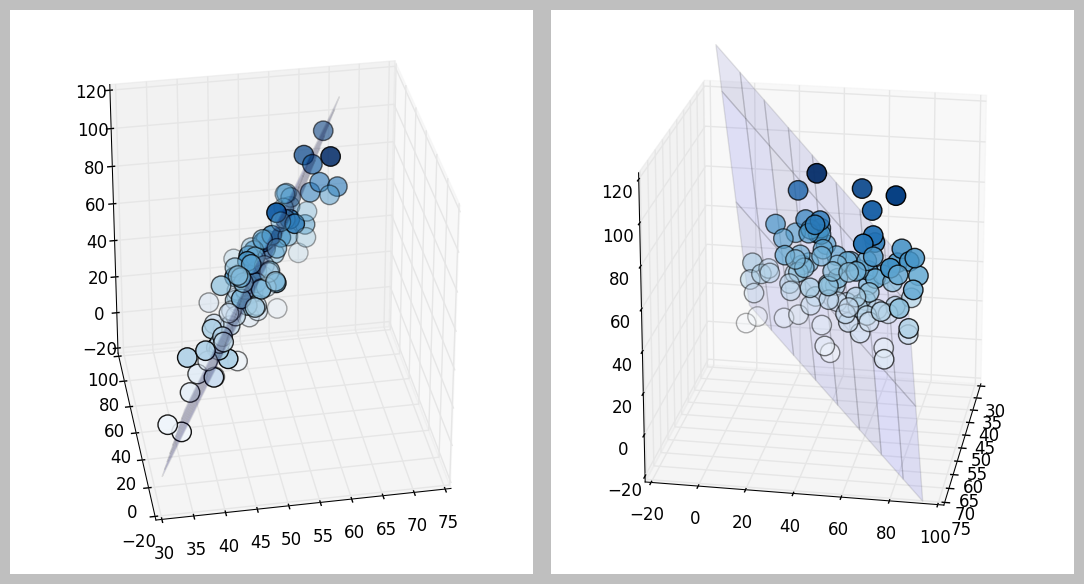

In [22]:
from mpl_toolkits.mplot3d import Axes3D

m = 100
mu = np.array([50, 50, 50])
r1_2 = 0.9
r1_3 = 0.7
r2_3 = 0.1
sigma1 = 5
sigma2 = 20
sigma3 = 20
c = np.array([[sigma1 ** 2, r1_2 * sigma1 * sigma2, r1_3 * sigma1 * sigma3],
             [r1_2 * sigma1 * sigma2, sigma2 ** 2, r2_3 * sigma2 * sigma3],
             [r1_3 * sigma1 * sigma3, r2_3 * sigma2 * sigma3, sigma3 ** 2]])
np.random.seed(142)
dataThreeD = np.random.multivariate_normal(mu, c, m)

from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import get_cmap
norm = Normalize()
cmap = get_cmap("Blues")
clrs = cmap(np.array(norm(dataThreeD[:,2])))[:,0:3]

fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(121, projection='3d')
ax.azim=-100
ax.scatter(dataThreeD[:,0], dataThreeD[:,1], dataThreeD[:,2], c=clrs, s=14**2)

xx, yy = np.meshgrid(np.arange(-15, 10, 1), np.arange(-50, 30, 1))
normal = np.array([0.96981815, -0.188338, -0.15485978])
z = (-normal[0] * xx - normal[1] * yy) * 1. / normal[2]
xx = xx + 50
yy = yy + 50
z = z + 50

ax.set_zlim((-20, 120)), ax.set_ylim((-20, 100)), ax.set_xlim((30, 75))
ax.plot_surface(xx, yy, z, alpha=.10)

ax = fig.add_subplot(122, projection='3d')
ax.azim=10
ax.elev=20
#ax.dist=8
ax.scatter(dataThreeD[:,0], dataThreeD[:,1], dataThreeD[:,2], c=clrs, s=14**2)

ax.set_zlim((-20, 120)), ax.set_ylim((-20, 100)), ax.set_xlim((30, 75))
ax.plot_surface(xx, yy, z, alpha=.1)
plt.tight_layout()
pass

#### **(2c) 3D to 2D**
#### We will now use PCA to see if we can recover the 2-dimensional plane on which the data live. Parallelize the data, and use our PCA function from above, with $ \scriptsize k=2 $ components.

In [23]:
# TODO: Replace <FILL IN> with appropriate code
threeDData = sc.parallelize(dataThreeD)
componentsThreeD, threeDScores, eigenvaluesThreeD = pca(threeDData)

print 'componentsThreeD: \n{0}'.format(componentsThreeD)
print ('\nthreeDScores (first three): \n{0}'
       .format('\n'.join(map(str, threeDScores.take(3)))))
print '\neigenvaluesThreeD: \n{0}'.format(eigenvaluesThreeD)

componentsThreeD: 
[[ 0.23952078  0.045635  ]
 [ 0.61699931  0.76409466]
 [ 0.74962768 -0.64348799]]

threeDScores (first three): 
[ 85.25798606  -8.29694407]
[ 89.66337911  15.73381517]
[ 75.92616872 -20.5015709 ]

eigenvaluesThreeD: 
[ 614.46863537  349.47737219    5.85043581]


In [24]:
# TEST 3D to 2D (2c)
Test.assertEquals(componentsThreeD.shape, (3, 2), 'incorrect shape for componentsThreeD')
Test.assertTrue(np.allclose(np.sum(eigenvaluesThreeD), 969.796443367),
                'incorrect value for eigenvaluesThreeD')
Test.assertTrue(np.allclose(np.abs(np.sum(componentsThreeD)), 1.77238943258),
                'incorrect value for componentsThreeD')
Test.assertTrue(np.allclose(np.abs(np.sum(threeDScores.take(3))), 237.782834092),
                'incorrect value for threeDScores')

1 test passed.
1 test passed.
1 test passed.
1 test passed.


#### **Visualization 4: 2D representation of 3D data**
#### See the 2D version of the data that captures most of its original structure.  Note that darker blues correspond to points with higher values for the original data's third dimension.

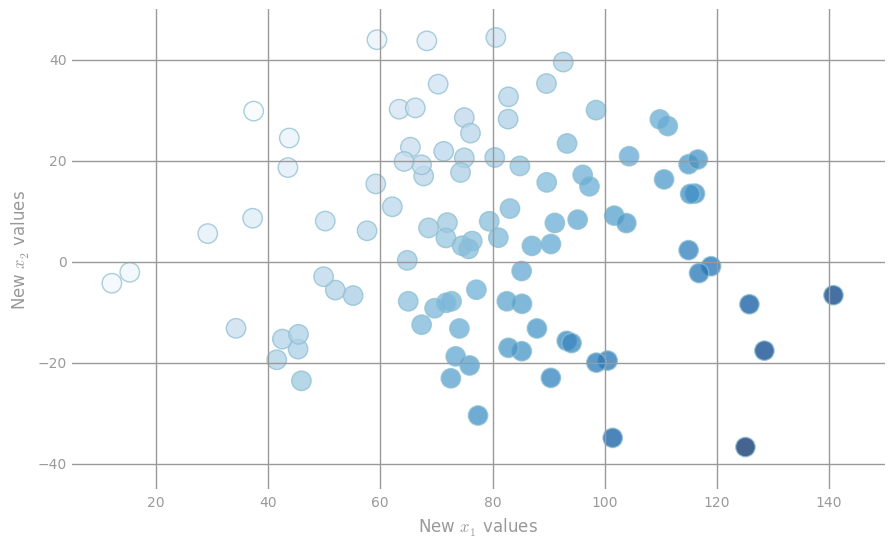

In [25]:
scoresThreeD = np.asarray(threeDScores.collect())

# generate layout and plot data
fig, ax = preparePlot(np.arange(20, 150, 20), np.arange(-40, 110, 20))
ax.set_xlabel(r'New $x_1$ values'), ax.set_ylabel(r'New $x_2$ values')
ax.set_xlim(5, 150), ax.set_ylim(-45, 50)
plt.scatter(scoresThreeD[:,0], scoresThreeD[:,1], s=14**2, c=clrs, edgecolors='#8cbfd0', alpha=0.75)
pass

#### **(2d) Variance explained**
#### Finally, let's quantify how much of the variance is being captured by PCA in each of the three synthetic datasets we've analyzed.  To do this, we'll compute the fraction of retained variance by the top principal components.  Recall that the eigenvalue corresponding to each principal component captures the variance along this direction.  If our initial data is $\scriptsize d$-dimensional, then the total variance in our data equals: $ \scriptsize \sum_{i=1}^d \lambda_i $, where $\scriptsize \lambda_i$ is the eigenvalue corresponding to the $\scriptsize i$th principal component. Moreover, if we use PCA with some $\scriptsize k < d$, then we can compute the variance retained by these principal components by adding the top $\scriptsize k$ eigenvalues.  The fraction of retained variance equals the sum of the top $\scriptsize k$ eigenvalues divided by the sum of all of the eigenvalues.

In [26]:
# TODO: Replace <FILL IN> with appropriate code
def varianceExplained(data, k=1):
    """Calculate the fraction of variance explained by the top `k` eigenvectors.

    Args:
        data (RDD of np.ndarray): An RDD that contains NumPy arrays which store the
            features for an observation.
        k: The number of principal components to consider.

    Returns:
        float: A number between 0 and 1 representing the percentage of variance explained
            by the top `k` eigenvectors.
    """
    components, scores, eigenvalues = pca(data, k)
    return eigenvalues[:k].sum() / eigenvalues.sum()

varianceRandom1 = varianceExplained(randomData, 1)
varianceCorrelated1 = varianceExplained(correlatedData, 1)
varianceRandom2 = varianceExplained(randomData, 2)
varianceCorrelated2 = varianceExplained(correlatedData, 2)
varianceThreeD2 = varianceExplained(threeDData, 2)
print ('Percentage of variance explained by the first component of randomData: {0:.1f}%'
       .format(varianceRandom1 * 100))
print ('Percentage of variance explained by both components of randomData: {0:.1f}%'
       .format(varianceRandom2 * 100))
print ('\nPercentage of variance explained by the first component of correlatedData: {0:.1f}%'.
       format(varianceCorrelated1 * 100))
print ('Percentage of variance explained by both components of correlatedData: {0:.1f}%'
       .format(varianceCorrelated2 * 100))
print ('\nPercentage of variance explained by the first two components of threeDData: {0:.1f}%'
       .format(varianceThreeD2 * 100))

Percentage of variance explained by the first component of randomData: 58.8%
Percentage of variance explained by both components of randomData: 100.0%

Percentage of variance explained by the first component of correlatedData: 93.4%
Percentage of variance explained by both components of correlatedData: 100.0%

Percentage of variance explained by the first two components of threeDData: 99.4%


In [27]:
# TEST Variance explained (2d)
Test.assertTrue(np.allclose(varianceRandom1, 0.588017172066), 'incorrect value for varianceRandom1')
Test.assertTrue(np.allclose(varianceCorrelated1, 0.933608329586),
                'incorrect value for varianceCorrelated1')
Test.assertTrue(np.allclose(varianceRandom2, 1.0), 'incorrect value for varianceRandom2')
Test.assertTrue(np.allclose(varianceCorrelated2, 1.0), 'incorrect value for varianceCorrelated2')
Test.assertTrue(np.allclose(varianceThreeD2, 0.993967356912), 'incorrect value for varianceThreeD2')

1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.


 
### **Part 3:  Parse, inspect, and preprocess neuroscience data then perform PCA **

 
#### **Data introduction**
#### A central challenge in neuroscience is understanding the organization and function of neurons, the cells responsible for processing and representing information in the brain. New technologies make it possible to monitor the responses of large populations of neurons in awake animals. In general, neurons communicate through electrical impulses that must be recorded with electrodes, which is a challenging process. As an alternative, we can genetically engineer animals so that their neurons express special proteins that flouresce or light up when active, and then use microscopy to record neural activity as images. A recently developed method called light-sheet microscopy lets us do this in a special, transparent animal, the larval zebrafish, over nearly its entire brain. The resulting data are time-varying images containing the activity of hundreds of thousands of neurons. Given the raw data, which is enormous, we want to find compact spatial and temporal patterns: Which groups of neurons are active together? What is the time course of their activity? Are those patterns specific to particular events happening during the experiment (e.g. a stimulus that we might present). PCA is a powerful technique for finding spatial and temporal patterns in these kinds of data, and that's what we'll explore here!

#### **(3a) Load neuroscience data**
#### In the next sections we will use PCA to capture structure in neural datasets. Before doing the analysis, we will load and do some basic inspection of the data. The raw data are currently stored as a text file. Every line in the file contains the time series of image intensity for a single pixel in a time-varying image (i.e. a movie). The first two numbers in each line are the spatial coordinates of the pixel, and the remaining numbers are the time series. We'll use first() to inspect a single row, and print just the first 100 characters.

In [29]:
import os
baseDir = os.path.join('data')
inputPath = os.path.join('cs190', 'neuro.txt')

inputFile = os.path.join(baseDir, inputPath)

lines = sc.textFile(inputFile)
print lines.first()[0:100]

# Check that everything loaded properly
assert len(lines.first()) == 1397
assert lines.count() == 46460

0 0 103 103.7 103.2 102.7 103.8 102.8 103 103.3 103.8 103.2 102.1 103.5 103.2 102.7 103.1 102.2 102.


#### **(3b) Parse the data**
#### Parse the data into a key-value representation. We want each key to be a tuple of two-dimensional spatial coordinates and each value to be a NumPy array storing the associated time series. Write a function that converts a line of text into a (`tuple`, `np.ndarray`) pair. Then apply this function to each record in the RDD, and inspect the first entry of the new parsed data set. Now would be a good time to cache the data, and force a computation by calling count, to ensure the data are cached.

In [37]:
# TODO: Replace <FILL IN> with appropriate code
def parse(line):
    """Parse the raw data into a (`tuple`, `np.ndarray`) pair.

    Note:
        You should store the pixel coordinates as a tuple of two ints and the elements of the pixel intensity
        time series as an np.ndarray of floats.

    Args:
        line (str): A string representing an observation.  Elements are separated by spaces.  The
            first two elements represent the coordinates of the pixel, and the rest of the elements
            represent the pixel intensity over time.

    Returns:
        tuple of tuple, np.ndarray: A (coordinate, pixel intensity array) `tuple` where coordinate is
            a `tuple` containing two values and the pixel intensity is stored in an NumPy array
            which contains 240 values.
    """
    line = line.strip().split()
    return ((int(line[0]), int(line[1])), np.array(line[2:], dtype=np.float64))

rawData = lines.map(parse)
rawData.cache()
entry = rawData.first()
print 'Length of movie is {0} seconds'.format(len(entry[1]))
print 'Number of pixels in movie is {0:,}'.format(rawData.count())
print ('\nFirst entry of rawData (with only the first five values of the NumPy array):\n({0}, {1})'
       .format(entry[0], entry[1][:5]))

Length of movie is 240 seconds
Number of pixels in movie is 46,460

First entry of rawData (with only the first five values of the NumPy array):
((0, 0), [ 103.   103.7  103.2  102.7  103.8])


In [38]:
# TEST Parse the data (3b)
Test.assertTrue(isinstance(entry[0], tuple), "entry's key should be a tuple")
Test.assertEquals(len(entry), 2, 'entry should have a key and a value')
Test.assertTrue(isinstance(entry[0][1], int), 'coordinate tuple should contain ints')
Test.assertEquals(len(entry[0]), 2, "entry's key should have two values")
Test.assertTrue(isinstance(entry[1], np.ndarray), "entry's value should be an np.ndarray")
Test.assertTrue(isinstance(entry[1][0], np.float), 'the np.ndarray should consist of np.float values')
Test.assertEquals(entry[0], (0, 0), 'incorrect key for entry')
Test.assertEquals(entry[1].size, 240, 'incorrect length of entry array')
Test.assertTrue(np.allclose(np.sum(entry[1]), 24683.5), 'incorrect values in entry array')

1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.


#### **(3c) Min and max flouresence**
#### Next we'll do some basic preprocessing on the data. The raw time-series data are in units of image flouresence, and baseline flouresence varies somewhat arbitrarily from pixel to pixel. First, compute the minimum and maximum values across all pixels.

In [47]:
# TODO: Replace <FILL IN> with appropriate code
mn = rawData.flatMap(lambda x: x[1]).min()
mx = rawData.flatMap(lambda x: x[1]).max()

print mn, mx

100.6 940.8


In [48]:
# TEST Min and max flouresence (3c)
Test.assertTrue(np.allclose(mn, 100.6), 'incorrect value for mn')
Test.assertTrue(np.allclose(mx, 940.8), 'incorrect value for mx')

1 test passed.
1 test passed.


#### **Visualization 5: Pixel intensity**
#### Let's now see how a random pixel varies in value over the course of the time series.  We'll visualize a pixel that exhibits a standard deviation of over 100.

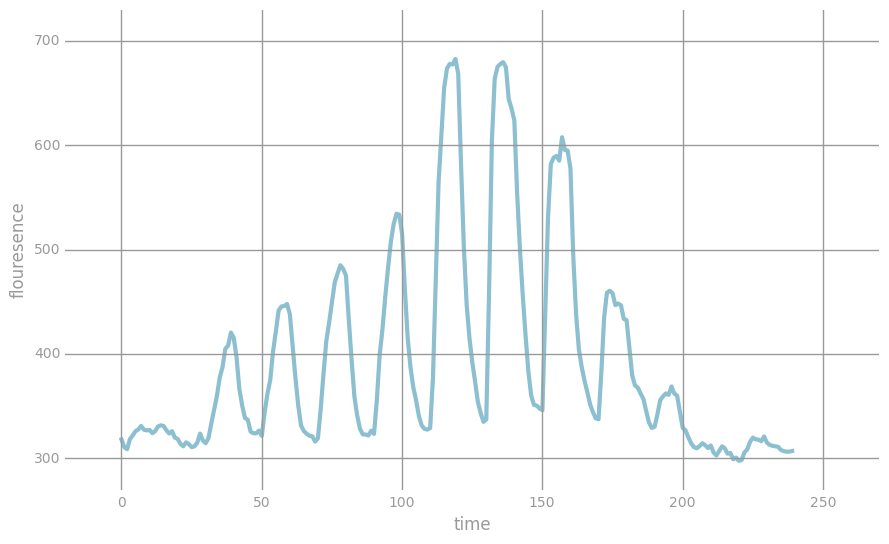

In [49]:
example = rawData.filter(lambda (k, v): np.std(v) > 100).values().first()

# generate layout and plot data
fig, ax = preparePlot(np.arange(0, 300, 50), np.arange(300, 800, 100))
ax.set_xlabel(r'time'), ax.set_ylabel(r'flouresence')
ax.set_xlim(-20, 270), ax.set_ylim(270, 730)
plt.plot(range(len(example)), example, c='#8cbfd0', linewidth='3.0')
pass

#### **(3d) Fractional signal change**
####To convert from these raw flouresence units to more intuitive units of fractional signal change, write a function that takes a time series for a particular pixel and subtracts and divides by the mean.  Then apply this function to all the pixels. Confirm that this changes the maximum and minimum values.

In [50]:
# TODO: Replace <FILL IN> with appropriate code
def rescale(ts):
    """Take a np.ndarray and return the standardized array by subtracting and dividing by the mean.

    Note:
        You should first subtract the mean and then divide by the mean.

    Args:
        ts (np.ndarray): Time series data (`np.float`) representing pixel intensity.

    Returns:
        np.ndarray: The times series adjusted by subtracting the mean and dividing by the mean.
    """
    return (ts - ts.mean()) / ts.mean()

scaledData = rawData.mapValues(lambda v: rescale(v))
mnScaled = scaledData.map(lambda (k, v): v).map(lambda v: min(v)).min()
mxScaled = scaledData.map(lambda (k, v): v).map(lambda v: max(v)).max()
print mnScaled, mxScaled

-0.271512880125 0.905448764348


In [51]:
# TEST Fractional signal change (3d)
Test.assertTrue(isinstance(scaledData.first()[1], np.ndarray), 'incorrect type returned by rescale')
Test.assertTrue(np.allclose(mnScaled, -0.27151288), 'incorrect value for mnScaled')
Test.assertTrue(np.allclose(mxScaled, 0.90544876), 'incorrect value for mxScaled')

1 test passed.
1 test passed.
1 test passed.


#### **Visualization 6: Normalized data**
#### Now that we've normalized our data, let's once again see how a random pixel varies in value over the course of the time series.  We'll visualize a pixel that exhibits a standard deviation of over 0.1.  Note the change in scale on the y-axis compared to the previous visualization.

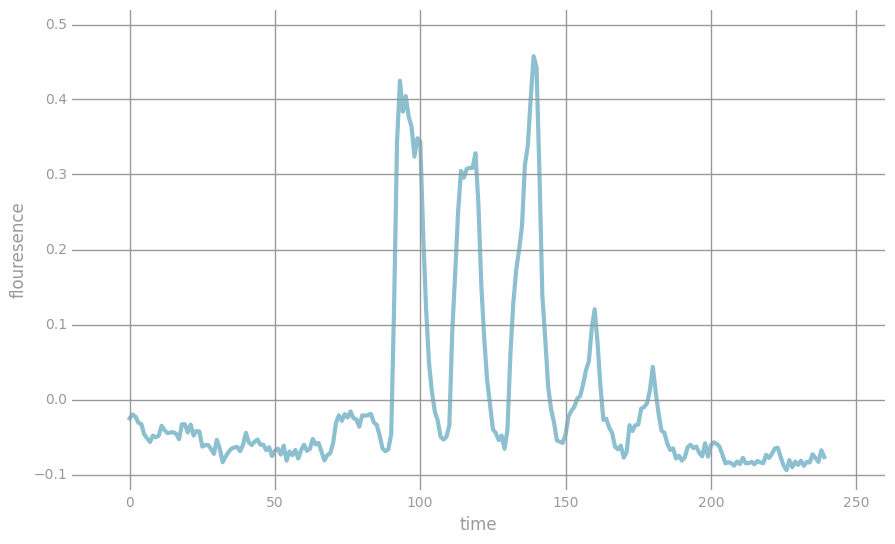

In [52]:
example = scaledData.filter(lambda (k, v): np.std(v) > 0.1).values().first()

# generate layout and plot data
fig, ax = preparePlot(np.arange(0, 300, 50), np.arange(-.1, .6, .1))
ax.set_xlabel(r'time'), ax.set_ylabel(r'flouresence')
ax.set_xlim(-20, 260), ax.set_ylim(-.12, .52)
plt.plot(range(len(example)), example, c='#8cbfd0', linewidth='3.0')
pass

#### **(3e) PCA on the scaled data**
#### We now have a preprocessed dataset with $\scriptsize n = 46460$ pixels and $\scriptsize d = 240$ seconds of time series data for each pixel.  We can interpret the pixels as our observations and each pixel value in the time series as a feature.  We would like to find patterns in brain activity during this time series, and we expect to find correlations over time.  We can thus use PCA to find a more compact representation of our data and allow us to visualize it.
 
#### Use the `pca` function from Part (2a) to perform PCA on the preprocessed neuroscience data with $\scriptsize k = 3$, resulting in a new low-dimensional 46460 by 3 dataset.  The `pca` function takes an RDD of arrays, but `data` is an RDD of key-value pairs, so you'll need to extract the values.

In [55]:
# TODO: Replace <FILL IN> with appropriate code
# Run pca using scaledData
componentsScaled, scaledScores, eigenvaluesScaled = pca(scaledData.values(), k=3)

In [56]:
# TEST PCA on the scaled data (3e)
Test.assertEquals(componentsScaled.shape, (240, 3), 'incorrect shape for componentsScaled')
Test.assertTrue(np.allclose(np.abs(np.sum(componentsScaled[:5, :])), 0.283150995232),
                'incorrect value for componentsScaled')
Test.assertTrue(np.allclose(np.abs(np.sum(scaledScores.take(3))), 0.0285507449251),
                'incorrect value for scaledScores')
Test.assertTrue(np.allclose(np.sum(eigenvaluesScaled[:5]), 0.206987501564),
                'incorrect value for eigenvaluesScaled')

1 test passed.
1 test passed.
1 test passed.
1 test passed.


#### **Visualization 7: Top two components as images**
#### Now, we'll view the scores for the top two component as images.  Note that we reshape the vectors by the dimensions of the original image, 230 x 202.
#### These graphs map the values for the single component to a grayscale image.  This provides us with a visual representation which we can use to see the overall structure of the zebrafish brain and to identify where high and low values occur.  However, using this representation, there is a substantial amount of useful information that is difficult to interpret.  In the next visualization, we'll see how we can improve interpretability by combining the two principal components into a single image using a color mapping.

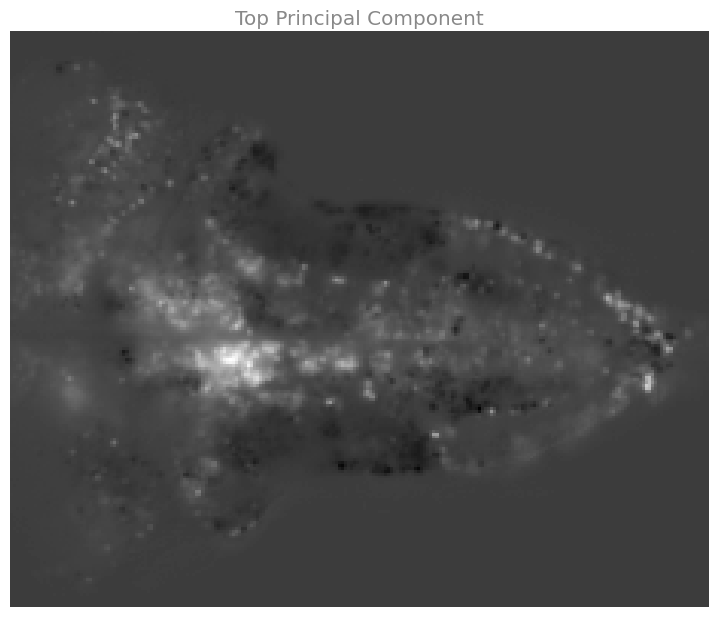

In [57]:
import matplotlib.cm as cm

scoresScaled = np.vstack(scaledScores.collect())
imageOneScaled = scoresScaled[:,0].reshape(230, 202).T

# generate layout and plot data
fig, ax = preparePlot(np.arange(0, 10, 1), np.arange(0, 10, 1), figsize=(9.0, 7.2), hideLabels=True)
ax.grid(False)
ax.set_title('Top Principal Component', color='#888888')
image = plt.imshow(imageOneScaled,interpolation='nearest', aspect='auto', cmap=cm.gray)
pass

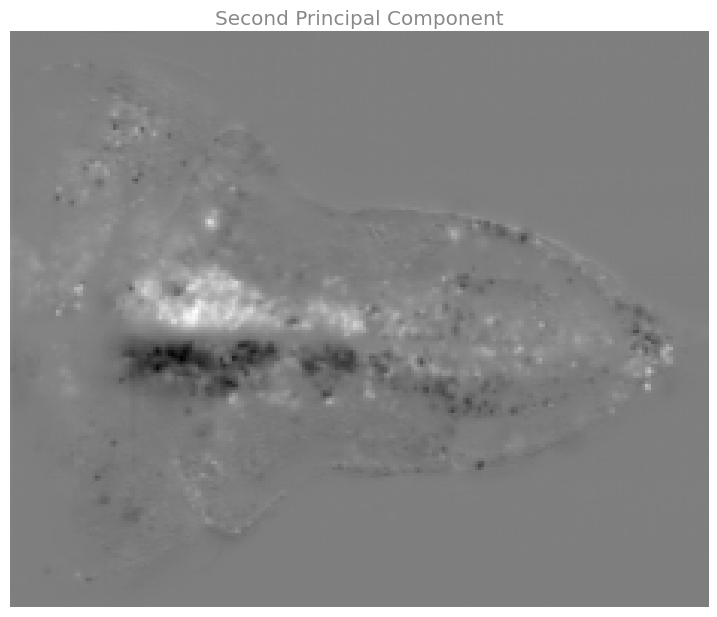

In [58]:
imageTwoScaled = scoresScaled[:,1].reshape(230, 202).T

# generate layout and plot data
fig, ax = preparePlot(np.arange(0, 10, 1), np.arange(0, 10, 1), figsize=(9.0, 7.2), hideLabels=True)
ax.grid(False)
ax.set_title('Second Principal Component', color='#888888')
image = plt.imshow(imageTwoScaled,interpolation='nearest', aspect='auto', cmap=cm.gray)
pass

#### **Visualization 8: Top two components as one image**
#### When we perform PCA and color neurons based on their location in the low-dimensional space, we can interpret areas with similar colors as exhibiting similar responses (at least in terms of the simple representation we recover with PCA). Below, the first graph shows how low-dimensional representations, which correspond to the first two principal components, are mapped to colors. The second graph shows the result of this color mapping using the zebrafish neural data.
 
####The second graph clearly exhibits patterns of neural similarity throughout different regions of the brain.  However, when performing PCA on the full dataset, there are multiple reasons why neurons might have similar responses. The neurons might respond similarly to different stimulus directions, their responses might have  similar temporal dynamics, or their response similarity could be influenced by both temporal and stimulus-specific factors. However, with our initial PCA analysis, we cannot pin down the underlying factors, and hence it is hard to interpret what "similarity" really means.

#### Optional Details: Note that we use [polar coordinates](https://en.wikipedia.org/wiki/Polar_coordinate_system) to map our low-dimensional points to colors.  Using polar coordinates provides us with an angle $ (\phi) $ and magnitude $ (\rho) $.  We then use the well-known polar color space, [hue-saturation-value](https://en.wikipedia.org/wiki/HSL_and_HSV) (HSV), and map the angle to hue and the magnitude to value (brightness).  This maps low magnitude points to black while allowing larger magnitude points to be differentiated by their angle. Additionally, the function `polarTransform` that maps low-dimensional representations to colors has an input parameter called `scale`, which we set  to 2.0, and you can try lower values for the two graphs to see more nuanced mappings -- values near 1.0 are particularly interesting.

In [59]:
# Adapted from python-thunder's Colorize.transform where cmap='polar'.
# Checkout the library at: https://github.com/thunder-project/thunder and
# http://thunder-project.org/

def polarTransform(scale, img):
    """Convert points from cartesian to polar coordinates and map to colors."""
    from matplotlib.colors import hsv_to_rgb

    img = np.asarray(img)
    dims = img.shape

    phi = ((np.arctan2(-img[0], -img[1]) + np.pi/2) % (np.pi*2)) / (2 * np.pi)
    rho = np.sqrt(img[0]**2 + img[1]**2)
    saturation = np.ones((dims[1], dims[2]))

    out = hsv_to_rgb(np.dstack((phi, saturation, scale * rho)))

    return np.clip(out * scale, 0, 1)

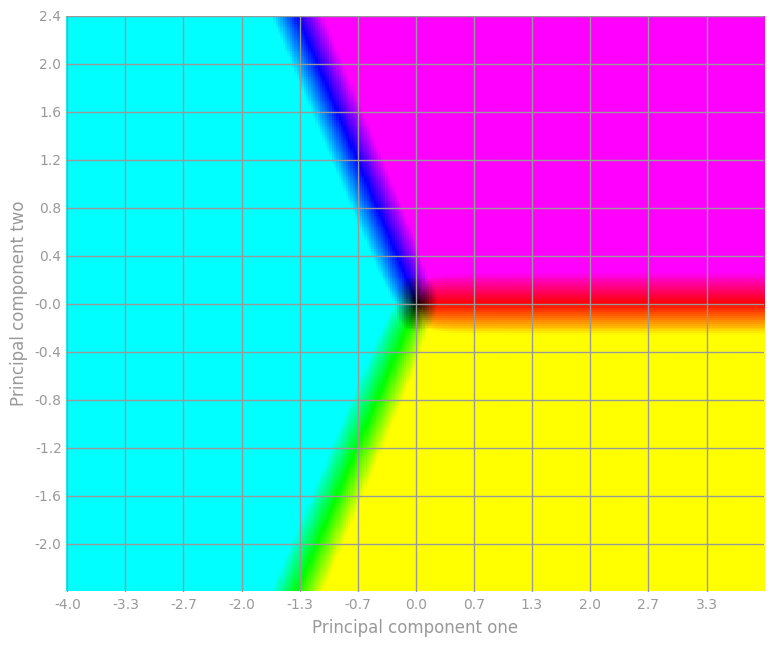

In [60]:
# Show the polar mapping from principal component coordinates to colors.
x1AbsMax = np.max(np.abs(imageOneScaled))
x2AbsMax = np.max(np.abs(imageTwoScaled))

numOfPixels = 300
x1Vals = np.arange(-x1AbsMax, x1AbsMax, (2 * x1AbsMax) / numOfPixels)
x2Vals = np.arange(x2AbsMax, -x2AbsMax, -(2 * x2AbsMax) / numOfPixels)
x2Vals.shape = (numOfPixels, 1)

x1Data = np.tile(x1Vals, (numOfPixels, 1))
x2Data = np.tile(x2Vals, (1, numOfPixels))

# Try changing the first parameter to lower values
polarMap = polarTransform(2.0, [x1Data, x2Data])

gridRange = np.arange(0, numOfPixels + 25, 25)
fig, ax = preparePlot(gridRange, gridRange, figsize=(9.0, 7.2), hideLabels=True)
image = plt.imshow(polarMap, interpolation='nearest', aspect='auto')
ax.set_xlabel('Principal component one'), ax.set_ylabel('Principal component two')
gridMarks = (2 * gridRange / float(numOfPixels) - 1.0)
x1Marks = x1AbsMax * gridMarks
x2Marks = -x2AbsMax * gridMarks
ax.get_xaxis().set_ticklabels(map(lambda x: '{0:.1f}'.format(x), x1Marks))
ax.get_yaxis().set_ticklabels(map(lambda x: '{0:.1f}'.format(x), x2Marks))
pass

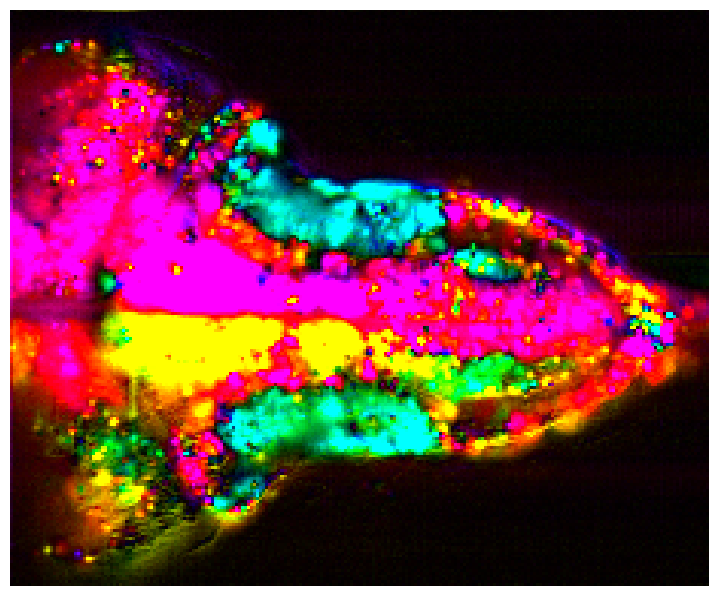

In [61]:
# Use the same transformation on the image data
# Try changing the first parameter to lower values
brainmap = polarTransform(2.0, [imageOneScaled, imageTwoScaled])

# generate layout and plot data
fig, ax = preparePlot(np.arange(0, 10, 1), np.arange(0, 10, 1), figsize=(9.0, 7.2), hideLabels=True)
ax.grid(False)
image = plt.imshow(brainmap,interpolation='nearest', aspect='auto')
pass

### **Part 4: Feature-based aggregation and PCA**

#### **(4a) Aggregation using arrays**
 
#### In the analysis in Part 3, we performed PCA on the full time series data, trying to find global patterns across all 240 seconds of the time series. However, our analysis doesn't use the fact that different events happened during those 240 seconds. Specifically, during those 240 seconds, the zebrafish was presented with 12 different direction-specific visual patterns, with each one lasting for 20 seconds, for a total of 12 x 20 = 240 features. Stronger patterns are likely to emerge if we incorporate knowledge of our experimental setup into our analysis.  As we'll see, we can isolate the impact of temporal response or direction-specific impact by appropriately aggregating our features.
 
#### In order to aggregate the features we will use basic ideas from matrix multiplication.  First, note that if we use `np.dot` with a two-dimensional array, then NumPy performs the equivalent matrix-multiply calculation.  For example, `np.array([[1, 2, 3], [4, 5, 6]]).dot(np.array([2, 0, 1]))` produces `np.array([5, 14])`.
#### $$\begin{bmatrix} 1 & 2 & 3 \\\ 4 & 5 & 6 \end{bmatrix} \begin{bmatrix} 2 \\\ 0 \\\ 1 \end{bmatrix} = \begin{bmatrix} 5 \\\ 14 \end{bmatrix} $$
#### By setting up our multi-dimensional array properly we can multiply it by a vector to perform certain aggregation operations.  For example, imagine we had a 3 dimensional vector, $ \scriptsize \begin{bmatrix} 1 & 2 & 3 \end{bmatrix}^\top $  and we wanted to create a 2 dimensional vector containing the sum of its first and last elements as one value and three times its second value as another value, i.e., $ \scriptsize \begin{bmatrix} 4 & 6 \end{bmatrix}^\top $. We can generate this result via matrix multiplication as follows: `np.array([[1, 0, 1], [0, 3, 0]]).dot(np.array([1, 2, 3])` which produces `np.array([4, 6]`.
#### $$\begin{bmatrix} 1 & 0 & 1 \\\ 0 & 3 & 0 \end{bmatrix} \begin{bmatrix} 1 \\\ 2 \\\ 3 \end{bmatrix} = \begin{bmatrix} 4 \\\ 6 \end{bmatrix} $$
#### For this exercise, you'll create several arrays that perform different types of aggregation.  The aggregation is specified in the comments before each array.  You should fill in the array values by hand.  We'll automate array creation in the next two exercises.

In [70]:
# TODO: Replace <FILL IN> with appropriate code
vector = np.array([0., 1., 2., 3., 4., 5.])

# Create a multi-dimensional array that when multiplied (using .dot) against vector, results in
# a two element array where the first element is the sum of the 0, 2, and 4 indexed elements of
# vector and the second element is the sum of the 1, 3, and 5 indexed elements of vector.
# This should be a 2 row by 6 column array
sumEveryOther = np.array([[1,0,1,0,1,0],[0,1,0,1,0,1]])

# Create a multi-dimensional array that when multiplied (using .dot) against vector, results in a
# three element array where the first element is the sum of the 0 and 3 indexed elements of vector,
# the second element is the sum of the 1 and 4 indexed elements of vector, and the third element is
# the sum of the 2 and 5 indexed elements of vector.
# This should be a 3 row by 6 column array
sumEveryThird = np.array([[1,0,0,1,0,0],[0,1,0,0,1,0],[0,0,1,0,0,1]])

# Create a multi-dimensional array that can be used to sum the first three elements of vector and
# the last three elements of vector, which returns a two element array with those values when dotted
# with vector.
# This should be a 2 row by 6 column array
sumByThree = np.array([[1,1,1,0,0,0],[0,0,0,1,1,1]])

# Create a multi-dimensional array that sums the first two elements, second two elements, and
# last two elements of vector, which returns a three element array with those values when dotted
# with vector.
# This should be a 3 row by 6 column array
sumByTwo = np.array([[1,1,0,0,0,0],[0,0,1,1,0,0],[0,0,0,0,1,1]])

print 'sumEveryOther.dot(vector):\t{0}'.format(sumEveryOther.dot(vector))
print 'sumEveryThird.dot(vector):\t{0}'.format(sumEveryThird.dot(vector))

print '\nsumByThree.dot(vector):\t{0}'.format(sumByThree.dot(vector))
print 'sumByTwo.dot(vector): \t{0}'.format(sumByTwo.dot(vector))

sumEveryOther.dot(vector):	[ 6.  9.]
sumEveryThird.dot(vector):	[ 3.  5.  7.]

sumByThree.dot(vector):	[  3.  12.]
sumByTwo.dot(vector): 	[ 1.  5.  9.]


In [71]:
# TEST Aggregation using arrays (4a)
Test.assertEquals(sumEveryOther.shape, (2, 6), 'incorrect shape for sumEveryOther')
Test.assertEquals(sumEveryThird.shape, (3, 6), 'incorrect shape for sumEveryThird')
Test.assertTrue(np.allclose(sumEveryOther.dot(vector), [6, 9]), 'incorrect value for sumEveryOther')
Test.assertTrue(np.allclose(sumEveryThird.dot(vector), [3, 5, 7]),
                'incorrect value for sumEveryThird')
Test.assertEquals(sumByThree.shape, (2, 6), 'incorrect shape for sumByThree')
Test.assertEquals(sumByTwo.shape, (3, 6), 'incorrect shape for sumByTwo')
Test.assertTrue(np.allclose(sumByThree.dot(vector),  [3, 12]), 'incorrect value for sumByThree')
Test.assertTrue(np.allclose(sumByTwo.dot(vector), [1, 5, 9]), 'incorrect value for sumByTwo')

1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.


#### **(4b) Recreate with `np.tile` and `np.eye`**
#### [np.tile](http://docs.scipy.org/doc/numpy/reference/generated/numpy.tile.html) is useful for repeating arrays in one or more dimensions.  For example, `np.tile(np.array([[1, 2], [3, 4]]), 2)` produces `np.array([[1, 2, 1, 2], [3, 4, 3, 4]]))`.
####  $$ np.tile( \begin{bmatrix} 1 & 2 \\\ 3 & 4 \end{bmatrix} , 2) \to \begin{bmatrix} 1 & 2 & 1& 2 \\\ 3 & 4 & 3 & 4 \end{bmatrix} $$
#### Recall that [np.eye](http://docs.scipy.org/doc/numpy/reference/generated/numpy.eye.html) can be used to create an identity array $ (\mathbf{I_n}) $.  For example, `np.eye(3)` produces `np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])`.
#### $$ np.eye( 3 ) \to \begin{bmatrix} 1 & 0 & 0 \\\ 0 & 1 & 0 \\\ 0 & 0 & 1 \end{bmatrix} $$
#### In this exercise, recreate `sumEveryOther` and `sumEveryThird` using `np.tile` and `np.eye`.

In [72]:
# Reference for what to recreate
print 'sumEveryOther: \n{0}'.format(sumEveryOther)
print '\nsumEveryThird: \n{0}'.format(sumEveryThird)

sumEveryOther: 
[[1 0 1 0 1 0]
 [0 1 0 1 0 1]]

sumEveryThird: 
[[1 0 0 1 0 0]
 [0 1 0 0 1 0]
 [0 0 1 0 0 1]]


In [73]:
# TODO: Replace <FILL IN> with appropriate code
# Use np.tile and np.eye to recreate the arrays
sumEveryOtherTile = np.tile(np.eye(2), 3)
sumEveryThirdTile = np.tile(np.eye(3), 2)

print sumEveryOtherTile
print 'sumEveryOtherTile.dot(vector): {0}'.format(sumEveryOtherTile.dot(vector))
print '\n', sumEveryThirdTile
print 'sumEveryThirdTile.dot(vector): {0}'.format(sumEveryThirdTile.dot(vector))

[[ 1.  0.  1.  0.  1.  0.]
 [ 0.  1.  0.  1.  0.  1.]]
sumEveryOtherTile.dot(vector): [ 6.  9.]

[[ 1.  0.  0.  1.  0.  0.]
 [ 0.  1.  0.  0.  1.  0.]
 [ 0.  0.  1.  0.  0.  1.]]
sumEveryThirdTile.dot(vector): [ 3.  5.  7.]


In [74]:
# TEST Recreate with `np.tile` and `np.eye` (4b)
Test.assertEquals(sumEveryOtherTile.shape, (2, 6), 'incorrect shape for sumEveryOtherTile')
Test.assertEquals(sumEveryThirdTile.shape, (3, 6), 'incorrect shape for sumEveryThirdTile')
Test.assertTrue(np.allclose(sumEveryOtherTile.dot(vector), [6, 9]),
                'incorrect value for sumEveryOtherTile')
Test.assertTrue(np.allclose(sumEveryThirdTile.dot(vector), [3, 5, 7]),
                'incorrect value for sumEveryThirdTile')

1 test passed.
1 test passed.
1 test passed.
1 test passed.


#### **(4c) Recreate with `np.kron` **
#### The Kronecker product is the generalization of outer products involving matrices, and we've included some examples below to illustrate the idea.  Please refer to the [Wikipedia page](https://en.wikipedia.org/wiki/Kronecker_product) for a detailed definition.  We can use [np.kron](http://docs.scipy.org/doc/numpy/reference/generated/numpy.kron.html) to compute Kronecker products and recreate the `sumBy` arrays.  Note that $ \otimes $ indicates a Kronecker product.
#### $$ \begin{bmatrix} 1 & 2 \\\ 3 & 4 \end{bmatrix} \otimes \begin{bmatrix} 1 & 2 \end{bmatrix}  = \begin{bmatrix} 1 \cdot 1 & 1 \cdot 2 & 2 \cdot 1 & 2 \cdot 2 \\\ 3 \cdot 1 & 3 \cdot 2 & 4 \cdot 1 & 4 \cdot 2 \end{bmatrix} = \begin{bmatrix} 1 & 2 & 2 & 4 \\\ 3 & 6 & 4 & 8 \end{bmatrix}  $$
#### We can see how the Kronecker product continues to expand if we add another row to the second array.
#### $$ \begin{bmatrix} 1 & 2 \\\ 3 & 4 \end{bmatrix} \otimes \begin{bmatrix} 1 & 2 \\\ 3 & 4 \end{bmatrix} = \begin{bmatrix} 1 \cdot 1 & 1 \cdot 2 & 2 \cdot 1 & 2 \cdot 2 \\\ 1 \cdot 3 & 1 \cdot 4 & 2 \cdot 3 & 2 \cdot 4 \\\ 3 \cdot 1 & 3 \cdot 2 & 4 \cdot 1 & 4 \cdot 2 \\\ 3 \cdot 3 & 3 \cdot 4 & 4 \cdot 3 & 4 \cdot 4 \end{bmatrix} = \begin{bmatrix} 1 & 2 & 2 & 4 \\\ 3 & 4 & 6 & 8 \\\ 3 & 6 & 4 & 8 \\\ 9 & 12 & 12 & 16 \end{bmatrix} $$
#### For this exercise, you'll recreate the `sumByThree` and `sumByTwo` arrays using `np.kron`, `np.eye`, and `np.ones`.  Note that `np.ones` creates an array of all ones.

In [75]:
# Reference for what to recreate
print 'sumByThree: \n{0}'.format(sumByThree)
print '\nsumByTwo: \n{0}'.format(sumByTwo)

sumByThree: 
[[1 1 1 0 0 0]
 [0 0 0 1 1 1]]

sumByTwo: 
[[1 1 0 0 0 0]
 [0 0 1 1 0 0]
 [0 0 0 0 1 1]]


In [81]:
# TODO: Replace <FILL IN> with appropriate code
# Use np.kron, np.eye, and np.ones to recreate the arrays
sumByThreeKron = np.kron(np.eye(2), np.ones(3))
sumByTwoKron = np.kron(np.eye(3), np.ones(2))

print sumByThreeKron
print 'sumByThreeKron.dot(vector): {0}'.format(sumByThreeKron.dot(vector))
print '\n', sumByTwoKron
print 'sumByTwoKron.dot(vector): {0}'.format(sumByTwoKron.dot(vector))

[[ 1.  1.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  1.  1.]]
sumByThreeKron.dot(vector): [  3.  12.]

[[ 1.  1.  0.  0.  0.  0.]
 [ 0.  0.  1.  1.  0.  0.]
 [ 0.  0.  0.  0.  1.  1.]]
sumByTwoKron.dot(vector): [ 1.  5.  9.]


In [82]:
# TEST Recreate with `np.kron` (4c)
Test.assertEquals(sumByThreeKron.shape, (2, 6), 'incorrect shape for sumByThreeKron')
Test.assertEquals(sumByTwoKron.shape, (3, 6), 'incorrect shape for sumByTwoKron')
Test.assertTrue(np.allclose(sumByThreeKron.dot(vector),  [3, 12]),
                'incorrect value for sumByThreeKron')
Test.assertTrue(np.allclose(sumByTwoKron.dot(vector), [1, 5, 9]),
                'incorrect value for sumByTwoKron')

1 test passed.
1 test passed.
1 test passed.
1 test passed.


#### **(4d) Aggregate by time** As we discussed in Part (4a), we would like to incorporate knowledge of our experimental setup into our analysis. To do this, we'll first study the temporal aspects of neural response, by aggregating our features by time. In other words, we want to see how different pixels (and the underlying neurons captured in these pixels) react in each of the 20 seconds after a new visual pattern is displayed, regardless of what the pattern is.  Hence, instead of working with the 240 features individually, we'll aggregate the original features into 20 new features, where the first new feature captures the pixel response one second after a visual pattern appears, the second new feature is the response after two seconds, and so on.
 
#### We can perform this aggregation using a map operation. First, build a multi-dimensional array $ \scriptsize \mathbf{T} $ that, when dotted with a 240-dimensional vector, sums every 20-th component of this vector and returns a 20-dimensional vector. Note that this exercise is similar to (4b).  Once you have created your multi-dimensional array $ \scriptsize \mathbf{T} $, use a `map` operation with that array and each time series to generate a transformed dataset. We'll cache and count the output, as we'll be using it again.

In [98]:
# TODO: Replace <FILL IN> with appropriate code
# Create a multi-dimensional array to perform the aggregation
T = np.tile(np.eye(20), 12)

# Transform scaledData using T.  Make sure to retain the keys.
timeData = scaledData.map(lambda (x, y): (x, T.dot(y)))

timeData.cache()
print timeData.count()
print timeData.first()

46460
((0, 0), array([ 0.00802155,  0.00607693, -0.0075354 ,  0.00121539,  0.02163388,
        0.00121539, -0.03087082,  0.00510462,  0.01191079,  0.02455081,
       -0.0182308 ,  0.00802155, -0.00948002, -0.00948002,  0.02163388,
       -0.02212004,  0.00704924,  0.00121539, -0.01142464, -0.00850771]))


In [99]:
# TEST Aggregate by time (4d)
Test.assertEquals(T.shape, (20, 240), 'incorrect shape for T')
timeDataFirst = timeData.values().first()
timeDataFifth = timeData.values().take(5)[4]
Test.assertEquals(timeData.count(), 46460, 'incorrect length of timeData')
Test.assertEquals(timeDataFirst.size, 20, 'incorrect value length of timeData')
Test.assertEquals(timeData.keys().first(), (0, 0), 'incorrect keys in timeData')
Test.assertTrue(np.allclose(timeDataFirst[:2], [0.00802155, 0.00607693]),
                'incorrect values in timeData')
Test.assertTrue(np.allclose(timeDataFifth[-2:],[-0.00636676, -0.0179427]),
                'incorrect values in timeData')

1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.


#### **(4e) Obtain a compact representation**
#### We now have a time-aggregated dataset with $\scriptsize n = 46460$ pixels and $\scriptsize d = 20$ aggregated time features, and we want to use PCA to find a more compact representation.  Use the `pca` function from Part (2a) to perform PCA on the this data with $\scriptsize k = 3$, resulting in a new low-dimensional 46,460 by 3 dataset. As before, you'll need to extract the values from `timeData` since it is an RDD of key-value pairs.

In [101]:
# TODO: Replace <FILL IN> with appropriate code
componentsTime, timeScores, eigenvaluesTime = pca(timeData.values(), k=3)

print 'componentsTime: (first five) \n{0}'.format(componentsTime[:5,:])
print ('\ntimeScores (first three): \n{0}'
       .format('\n'.join(map(str, timeScores.take(3)))))
print '\neigenvaluesTime: (first five) \n{0}'.format(eigenvaluesTime[:5])

componentsTime: (first five) 
[[ 0.27392702 -0.16152431  0.01388556]
 [ 0.09941893 -0.31968127 -0.34738824]
 [-0.03376505 -0.32933108 -0.35606954]
 [-0.12092744 -0.2845482  -0.27232364]
 [-0.18219248 -0.22998061 -0.12248985]]

timeScores (first three): 
[-0.00720617 -0.00292979 -0.00223645]
[ 0.02353076 -0.00197457  0.00362094]
[ 0.01310623  0.00123069 -0.00582974]

eigenvaluesTime: (first five) 
[ 0.77528991  0.05038881  0.01173423  0.0059711   0.00138073]


In [102]:
# TEST Obtain a compact representation (4e)
Test.assertEquals(componentsTime.shape, (20, 3), 'incorrect shape for componentsTime')
Test.assertTrue(np.allclose(np.abs(np.sum(componentsTime[:5, :])), 2.37299020),
                'incorrect value for componentsTime')
Test.assertTrue(np.allclose(np.abs(np.sum(timeScores.take(3))), 0.0213119114),
                'incorrect value for timeScores')
Test.assertTrue(np.allclose(np.sum(eigenvaluesTime[:5]), 0.844764792),
                'incorrect value for eigenvaluesTime')

1 test passed.
1 test passed.
1 test passed.
1 test passed.


#### ** Visualization 9: Top two components by time **
#### Let's view the scores from the first two PCs as a composite image. When we preprocess by aggregating by time and then perform PCA, we are only looking at variability related to temporal dynamics. As a result, if neurons appear similar -- have similar colors -- in the resulting image, it means that their responses vary similarly over time, regardless of how they might be encoding direction. In the image below, we can define the midline as the horizontal line across the middle of the brain.  We see clear patterns of neural activity in different parts of the brain, and crucially note that the regions on either side of the midline are similar, which suggests that temporal dynamics do not differ across the two sides of the brain.

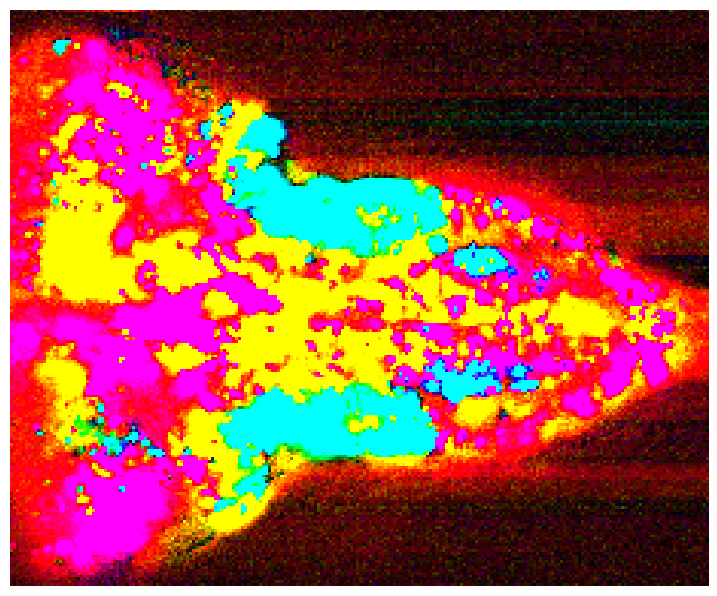

In [103]:
scoresTime = np.vstack(timeScores.collect())
imageOneTime = scoresTime[:,0].reshape(230, 202).T
imageTwoTime = scoresTime[:,1].reshape(230, 202).T
brainmap = polarTransform(3, [imageOneTime, imageTwoTime])

# generate layout and plot data
fig, ax = preparePlot(np.arange(0, 10, 1), np.arange(0, 10, 1), figsize=(9.0, 7.2), hideLabels=True)
ax.grid(False)
image = plt.imshow(brainmap,interpolation='nearest', aspect='auto')
pass

#### **(4f) Aggregate by direction**
#### Next, let's perform a second type of feature aggregation so that we can study the direction-specific aspects of neural response, by aggregating our features by direction. In other words, we want to see how different pixels (and the underlying neurons captured in these pixels) react when the zebrafish is presented with 12 direction-specific patterns, ignoring the temporal aspect of the reaction.  Hence, instead of working with the 240 features individually, we'll aggregate the original features into 12 new features, where the first new feature captures the average pixel response to the first direction-specific visual pattern, the second new feature is the response to the second direction-specific visual pattern, and so on.
 
#### As in Part (4c), we'll design a multi-dimensional array $ \scriptsize \mathbf{D} $ that, when multiplied by a 240-dimensional vector, sums the first 20 components, then the second 20 components, and so on. Note that this is similar to exercise (4c).  First create $ \scriptsize \mathbf{D} $, then use a `map` operation with that array and each time series to generate a transformed dataset. We'll cache and count the output, as we'll be using it again.

In [104]:
# TODO: Replace <FILL IN> with appropriate code
# Create a multi-dimensional array to perform the aggregation
D = np.kron(np.eye(12), np.ones(20))

# Transform scaledData using D.  Make sure to retain the keys.
directionData = scaledData.map(lambda (x, y): (x, D.dot(y)))

directionData.cache()
print directionData.count()
print directionData.first()

46460
((0, 0), array([ 0.03346365,  0.03638058, -0.02195799, -0.02487492,  0.00721129,
        0.00332206, -0.02098568,  0.00915591, -0.00542873, -0.01029027,
        0.0081836 , -0.01417951]))


In [105]:
# TEST Aggregate by direction (4f)
Test.assertEquals(D.shape, (12, 240), 'incorrect shape for D')
directionDataFirst = directionData.values().first()
directionDataFifth = directionData.values().take(5)[4]
Test.assertEquals(directionData.count(), 46460, 'incorrect length of directionData')
Test.assertEquals(directionDataFirst.size, 12, 'incorrect value length of directionData')
Test.assertEquals(directionData.keys().first(), (0, 0), 'incorrect keys in directionData')
Test.assertTrue(np.allclose(directionDataFirst[:2], [ 0.03346365,  0.03638058]),
                'incorrect values in directionData')
Test.assertTrue(np.allclose(directionDataFifth[:2], [ 0.01479147, -0.02090099]),
                'incorrect values in directionData')

1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.


#### **(4g) Compact representation of direction data**
#### We now have a direction-aggregated dataset with $\scriptsize n = 46460$ pixels and $\scriptsize d = 12$ aggregated direction features, and we want to use PCA to find a more compact representation.  Use the `pca` function from Part (2a) to perform PCA on the this data with $\scriptsize k = 3$, resulting in a new low-dimensional 46460 by 3 dataset. As before, you'll need to extract the values from `directionData` since it is an RDD of key-value pairs.

In [106]:
# TODO: Replace <FILL IN> with appropriate code
componentsDirection, directionScores, eigenvaluesDirection = pca(directionData.values(), k=3)

print 'componentsDirection: (first five) \n{0}'.format(componentsDirection[:5,:])
print ('\ndirectionScores (first three): \n{0}'
       .format('\n'.join(map(str, directionScores.take(3)))))
print '\neigenvaluesDirection: (first five) \n{0}'.format(eigenvaluesDirection[:5])

componentsDirection: (first five) 
[[-0.25952179  0.16201941  0.24947433]
 [-0.31369506 -0.09185175  0.29464223]
 [-0.21716693 -0.35944645  0.35296454]
 [-0.11517273 -0.37356905  0.07169062]
 [ 0.02996577 -0.36272623 -0.14783897]]

directionScores (first three): 
[-0.01622513  0.01322998  0.01322204]
[ 0.00999482  0.0652367  -0.04524758]
[ 0.004646    0.05751097  0.00756383]

eigenvaluesDirection: (first five) 
[ 0.96411048  0.77613553  0.12762987  0.09775924  0.04333691]


In [107]:
# TEST Compact representation of direction data (4g)
Test.assertEquals(componentsDirection.shape, (12, 3), 'incorrect shape for componentsDirection')
Test.assertTrue(np.allclose(np.abs(np.sum(componentsDirection[:5, :])), 1.080232069),
                'incorrect value for componentsDirection')
Test.assertTrue(np.allclose(np.abs(np.sum(directionScores.take(3))), 0.10993162084),
                'incorrect value for directionScores')
Test.assertTrue(np.allclose(np.sum(eigenvaluesDirection[:5]), 2.0089720377),
                'incorrect value for eigenvaluesDirection')

1 test passed.
1 test passed.
1 test passed.
1 test passed.


 
#### **Visualization 10: Top two components by direction**
#### Again, let's view the scores from the first two PCs as a composite image.  When we preprocess by averaging across time (group by direction), and then perform PCA, we are only looking at variability related to stimulus direction. As a result, if neurons appear similar -- have similar colors -- in the image, it means that their responses vary similarly across directions, regardless of how they evolve over time. In the image below, we see a different pattern of similarity across regions of the brain.  Moreover, regions on either side of the midline are colored differently, which suggests that we are looking at a property, direction selectivity, that has a different representation across the two sides of the brain.

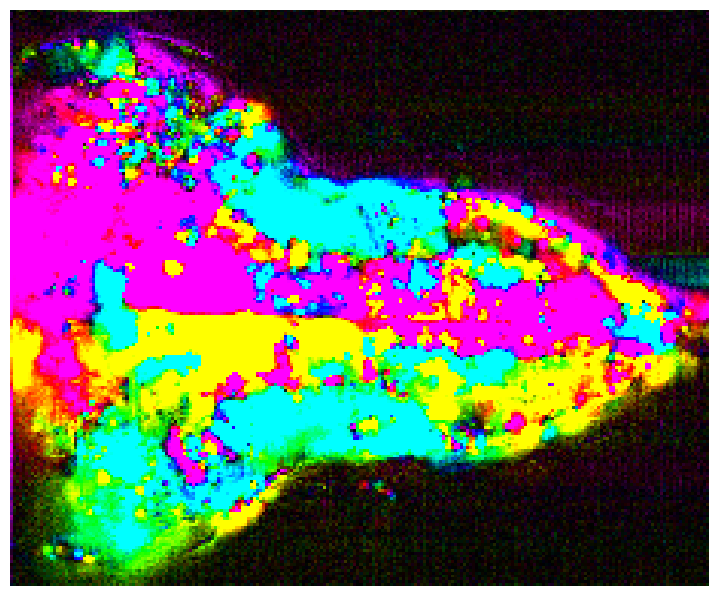

In [108]:
scoresDirection = np.vstack(directionScores.collect())
imageOneDirection = scoresDirection[:,0].reshape(230, 202).T
imageTwoDirection = scoresDirection[:,1].reshape(230, 202).T
brainmap = polarTransform(2, [imageOneDirection, imageTwoDirection])
# with thunder: Colorize(cmap='polar', scale=2).transform([imageOneDirection, imageTwoDirection])

# generate layout and plot data
fig, ax = preparePlot(np.arange(0, 10, 1), np.arange(0, 10, 1), figsize=(9.0, 7.2), hideLabels=True)
ax.grid(False)
image = plt.imshow(brainmap, interpolation='nearest', aspect='auto')
pass

#### **(4h) Next steps**
#### In the analyses above we have successfully identified regions of the brain that encode particular properties, e.g., a particular temporal pattern or selectivity to a stimulus. However, this is only the first step! These exploratory analyses are typically followed with more targeted investigation, both through analysis and experiment. For example, we might find all neurons that prefer one stimulus direction, and then do an experiment in which we stimulate or inactivate only those neurons and look at the effect on the animal's behavior. Alternatively, we might subdivide neurons into groups based on simple forms of stimulus selectivity like the ones analyzed here, and then estimate coupling across different neuronal populations, i.e. can we predict one population's response as a function of another. This can  be framed as a massive pair-wise regression problem, related to techniques you learned earlier in the course, and demanding large-scale implementations.